
# Определение вероятной оценки фильма


## Цель проекта:
Найти взаимосвязь между рейтинговой оценкой фильма и его аннотацией, актерским составом, сценаристами.

## Гипотеза:
Мы предполагаем, что существует связь между рейтинговой оценкой фильма и его аннотацией, актерским составом, сценаристами.

## Описание проделанной работы:

### 1) Определение датасета и получение кратких сведений

### 2) Разведочный анализ

### 3) Токенезация, удаление знаков пунктуации, лемматизация значений столбца аннотаций

### 4) Частотный анализ слов в аннотациях

### 5) Выделение главных тематик топа фильмов

### 6) Обучение с учителем



## #Установка и импортирование библиотек


In [ ]:
!pip install pymorphy2 
!pip install pyLDAvis 

In [ ]:
# импортирование библиотеки pandas для работы с объетками DataFrames 
import pandas as pd 

# имортирование библиотек для обработки текста
import pymorphy2 # импортирование библиотеки для лемматизации русских слов
from nltk.tokenize import word_tokenize # импортирование токенайзера

from nltk import download
from nltk.corpus import stopwords # импортирование объекта со списком стоп слов
from string import punctuation # импортирование строки с символами пунктуации

# импортирование векторайзера для матрицы совместной встречаемости
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import TruncatedSVD

import numpy as np

import matplotlib.pyplot as plt

download("stopwords") # загрузка дополнительного пакета stopwords
download('punkt') #загрузка дополнительного пакета punkt

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

## Определение датасета и краткая информация о нём

In [ ]:
FILE_PATH = "kinopoisk-top250.csv"

In [ ]:
data_frame = pd.read_csv(FILE_PATH)  
data_frame.head(3)

,rating,movie,year,country,rating_ball,overview,director,screenwriter,actors,url_logo
0,0,Побег из Шоушенка,1994,США,9.111,Бухгалтер Энди Дюфрейн обвинён в убийстве собс...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Тим Роббинс; Морган Фриман; Боб Гантон; Уильям...,'https://st.kp.yandex.net/images/film_iphone/i...
1,1,Зеленая миля,1999,США,9.062,Пол Эджкомб — начальник блока смертников в тюр...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...,'https://st.kp.yandex.net/images/film_iphone/i...
2,2,Форрест Гамп,1994,США,8.913,От лица главного героя Форреста Гампа; слабоум...,Роберт Земекис,Эрик Рот; Уинстон Грум,Том Хэнкс; Робин Райт; Салли Филд; Гэри Синиз;...,'https://st.kp.yandex.net/images/film_iphone/i...


**Видно, что данный датасет содержит 10 характеристик 250-ти лучших фильмов данного сервиса** 

In [ ]:
data_frame.describe() # вывод краткой информации о столбцах с числовыми значениями

,rating,year,rating_ball
count,250.000000,250.000000,250.000000
mean,124.500000,1991.736000,8.231444
std,72.312977,19.015168,0.230376
min,0.000000,1921.000000,7.806000
25%,62.250000,1980.000000,8.063500
50%,124.500000,1997.500000,8.169000
75%,186.750000,2005.000000,8.355750
max,249.000000,2019.000000,9.111000


## Разведочный анализ

In [ ]:
data_frame = data_frame.drop(columns=["url_logo","rating"])

,movie,year,country,rating_ball,overview,director,screenwriter,actors
0,Побег из Шоушенка,1994,США,9.111,Бухгалтер Энди Дюфрейн обвинён в убийстве собс...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Тим Роббинс; Морган Фриман; Боб Гантон; Уильям...
1,Зеленая миля,1999,США,9.062,Пол Эджкомб — начальник блока смертников в тюр...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...
2,Форрест Гамп,1994,США,8.913,От лица главного героя Форреста Гампа; слабоум...,Роберт Земекис,Эрик Рот; Уинстон Грум,Том Хэнкс; Робин Райт; Салли Филд; Гэри Синиз;...


In [ ]:
years_frequency = data_frame["year"].value_counts() # запись частотности годов

years = years_frequency.keys() 
frequency = years_frequency.values

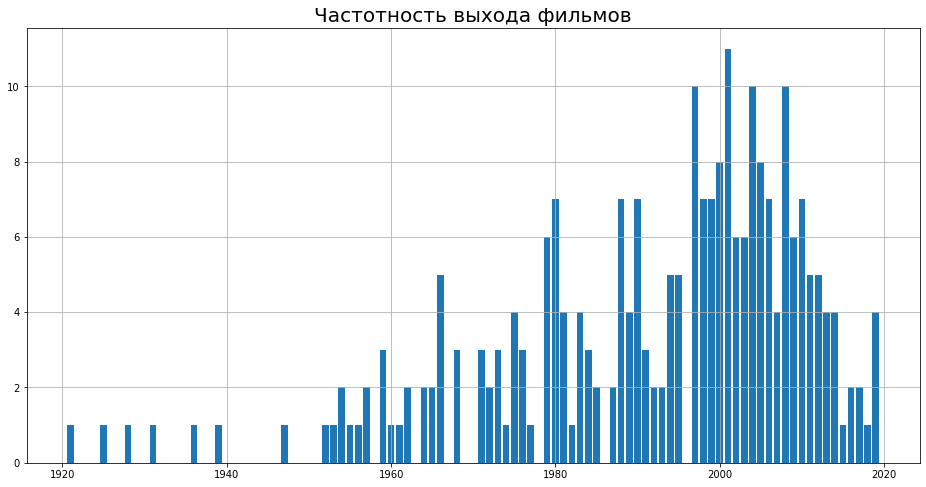

In [ ]:
fig, axes = plt.subplots(figsize = (16, 8)) # Создание графика и определение его размеров
axes.bar(years,frequency) # Определение метрик для графика (x,y) 
axes.set_title("Частотность выхода фильмов", fontsize=20) # Определение название графика
axes.grid(True) # Определение сетки для графика, для лучшей читабильности

In [ ]:
countries = data_frame["country"] # Запись значений со столбца Country

def country_counter(countries):
  counter = {}
  for sample in countries:
    if sample in counter:
      counter[sample] += 1
    else:
      counter[sample] = 1
  return counter

counter = country_counter(countries) # словарь - счетчик встречаемости стран 


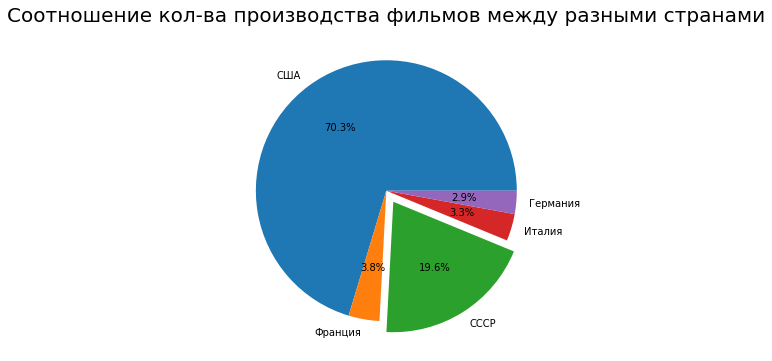

In [ ]:
countries = list(counter.keys())[:5] # Список 5-ти самых встречаемых стран в кинопроизводстве топ-250 картин
film_number = list(counter.values())[:5] # Количество встреч 5-ти самых встречаемых стран в кинопроизводстве топ-250 картин

fig2, axes2 = plt.subplots(figsize=(6,6)) # Определение графика и  его размеров
explode = (0,0,0.1,0,0) # Определение расстояния долей от центра pie графика 
axes2.pie(film_number, explode = explode, labels = countries, autopct="%1.1f%%") # Определение графика, как pie график и вставка метрик с параметрами отображения 
axes2.set_title("Соотношение кол-ва производства фильмов между разными странами",fontsize = 20) # Определение название графика
plt.show() # Вывод графика

## Токенезация, удаление знаков пунктуации, лемматизация значений столбца overview

In [ ]:
# Конвертирование строки пунктуационных символов во множество
punct = set(punctuation)
punct.update({"«", "—","»", "…", "..."})
ru_stop = set(stopwords.words("russian"))
ru_stop.update({"её","оба","обе","который","свой","это","весь","то","всё","самый"})

# Определяем объект MorphAnalyzer
morpheus = pymorphy2.MorphAnalyzer() 

In [ ]:
overviews = data_frame["overview"] # записываем в переменную контент колонки overvew 

In [ ]:
column_title = "setting"
data_frame[column_title] = "" # создание новой колонки с именем setting

def overviews_to_settings(overviews, column_title):
  string = 0
  for sample in overviews:
    counter = {} # словарь-счетчик слов каждого sample
    for word in word_tokenize(sample, language = "russian"): #токенизирование sample 
      if word[-1] == "…": # Фильтр для очистки токенизированных слов от многоточия в конце (пример: "славе…" --> "славе")
        word = word[:-1]
      word = morpheus.parse(word)[0].normalized.word # Лемматизируем слово
      if not(word in ru_stop or word in punct): 
        if word in counter:
          counter[word] += 1
        else:
          counter[word] = 1
    data_frame[column_title][string] = counter
    string += 1 

overviews_to_settings(overviews, column_title)

In [ ]:
data_frame = data_frame.drop(columns = ("overview"))
data_frame.head(3)


,movie,year,country,rating_ball,director,screenwriter,actors,setting
0,Побег из Шоушенка,1994,США,9.111,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Тим Роббинс; Морган Фриман; Боб Гантон; Уильям...,"{'бухгалтер': 1, 'энди': 2, 'дюфрейн': 1, 'обв..."
1,Зеленая миля,1999,США,9.062,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...,"{'пол': 2, 'эджкомба': 1, 'начальник': 1, 'бло..."
2,Форрест Гамп,1994,США,8.913,Роберт Земекис,Эрик Рот; Уинстон Грум,Том Хэнкс; Робин Райт; Салли Филд; Гэри Синиз;...,"{'лицо': 1, 'главное': 1, 'герой': 2, 'форрест..."


## Частотный анализ


In [ ]:
def sentence_cleaner(sample): # функция, убирающая стоп слова и знаки препинания, а также леммантизирующая оставшиеся слова 
  new_sentence = ""
  for word in word_tokenize(sample):
    if word[-1] == "…":
      word = word[:-1]
    word = morpheus.parse(word)[0].normalized.word
    if not(word in punct or word in ru_stop):
       new_sentence += word + " "
  return new_sentence

cleared_sentences = [sentence_cleaner(sample) for sample in overviews] 


In [ ]:
word_vectorizer = CountVectorizer() 

word_vectorizer.fit(cleared_sentences) 

table_content = word_vectorizer.transform(cleared_sentences) 


In [ ]:
terms = word_vectorizer.get_feature_names() 
words_amounts = table_content.toarray().sum(axis=0) 

all_samples_counter = dict(zip(terms, words_amounts))
all_samples_counter = pd.Series(all_samples_counter) 
all_samples_counter = all_samples_counter.sort_values(ascending = False) 

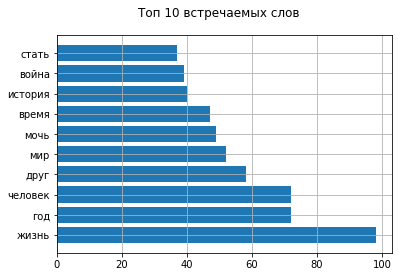

In [ ]:
top_10 = all_samples_counter.iloc[:10]  

fig3, axis3 = plt.subplots() 
fig3.suptitle("Топ 10 встречаемых слов")
axis3.barh(top_10.index, top_10.values) 
axis3.grid(True) 

## Обучение с учителем


Для поставленной задачи был выбран алгоритм рандомного дерева DecisionTreeRegressor, оценка качества модели производилась mean_absolute_error.

In [ ]:
y=data_frame['rating_ball']
x=data_frame['setting']

def f_p(x):
  elements = [element for element  in x]
  return ' '.join(elements)

x = x.apply(f_p)

# переводим строковой X в векторный вид
vectorizer = TfidfVectorizer()
X=vectorizer.fit_transform(x)

In [ ]:
# разбиваем X и y на тренировочные и тестовые данные
#test_size- выделяет для тестового набора 30%
# Суть параметра random_state (во всех функциях и методах из SciKit-Learn) в воспроизводимых случайных значениях. 
# Т.е. если явно задать значение random_state отличным от None - то генерируемые псевдослучайные величины будут иметь одни и те же значения при каждом вызове.
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,random_state=17)

In [ ]:
# проверяем точность рандомного дерева
# max_depth-максимальная шлубина дерева
# predict-передает на предсказание тестовый X_holdout
regr_tree = DecisionTreeRegressor(max_depth=5,random_state=17).fit(X_train,y_train)
pred = regr_tree.predict(X_holdout)
mean_absolute_error(y_holdout, pred)

0.19059044731424324

In [ ]:
# среднее значение по рейтингу
# mean-среднее значение по рейтингу
averege=data_frame['rating_ball'].mean()
averege_pred = [averege]*len(y_holdout)
mean_absolute_error(y_holdout, averege_pred)

0.18071696000000093

In [ ]:
dataf="Test.xlsx"
dataf=pd.read_excel(dataf)
new_data=dataf['overview']+' '+dataf['actors']+' '+dataf['screenwriter']

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#использование других данных для теста (самый лучший день)
# array([8.19314198]),в то время как реальный балл фильма 4.6
# токенизирует столбик с аннотацией
def tt(tit, wt):
  return word_tokenize(tit)
lem=pymorphy2.MorphAnalyzer()
def lemmatize(tt, lem):
  return [lem.parse(i)[0].normalized.word for i in tt]
tok_dataf = new_data.apply(lambda x: tt(x, word_tokenize))
tok_dataf = new_data.apply(word_tokenize)
lem_dataf= tok_dataf.apply(lambda x: lemmatize(x, lem))
x1=lem_dataf.apply(f_p)
X1=vectorizer.transform(x1)
regr_tree.predict(X1)

array([8.17519708])